# OUTLINE
<ol>
<li>Read the data from <a href="https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv">https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv</a>
<li>Remove any data that is outside the NYC bounding box
<ul>
<li>NYC bounding box: westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
</ul>
<li>Calculate taxi trip duration and save in a new column "duration"
<li>Convert duration into a float
<li>Do some basic analysis (see below)
<li>Add a day of week column
<li>Add an hour of day column
<li>Do some analysis (see below)
<li>Divide the data into zones
<ul>
<li>write a function createZoneTable(zone_factor) that divides the bounding box into zones
<li>create zone_factor * zone_factor zones
<li>Return a table (a list of lists) containing a zone id, and the coordinates of the zone
</ul>
<li>Write a function get_zone(lat,lon) that figures out the zone given a latitude and longitude
<li>Apply the function to the dataframe, first with pickup lats and longs; then with dropoff lats and longs. Create two new "pickup_zone" and "dropoff_zone" columns
<li>Do some analysis (see below)
<li>Using folium, draw a heatmap of the number of trips originating in each zone
<ul>
<li>Create a geojson object for all the zones 
<li>Create a df that contains zone numbers and the number of trips originating in each zone
<li>Use folium to create a heatmap
<li>Remove every zone that has 0 originating trips from the map.

<h2>Read the data</h2>


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('C:\\Users\April\Desktop\master_first_semester\data analytics\class_5\hw_5\yellow_tripdata_small_2016-01.csv')

<h2>Remove data outside the bounding box</h2>


In [3]:
westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
df = df[(df['pickup_longitude']<=eastlimit) & (df['pickup_longitude']>=westlimit) & (df['dropoff_longitude']<=eastlimit) & (df['dropoff_longitude']>=westlimit)]
df = df[(df['pickup_latitude']<=northlimit) & (df['pickup_latitude']>=southlimit) &(df['dropoff_latitude']<=northlimit) & (df['dropoff_latitude']>=southlimit)]

<h2>Add a column for taxi trip duration</h2>

In [4]:
import datetime
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [5]:
df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['duration']=df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']

<h2>Convert duration column into a float (number of seconds)</h2>

In [6]:
df['duration'] = df['duration'].apply(lambda x:x/np.timedelta64(1,'s'))

<h2>Remove data where duration is greater than 10000 seconds</h2>

In [7]:
df = df[df['duration']<=10000]

<h2>Plot duration and compare with a gamma distribution</h2>

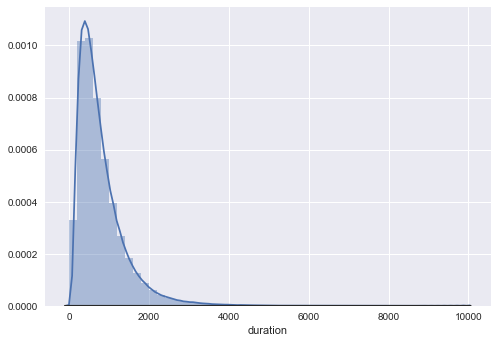

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from scipy import stats
sns.distplot(df['duration'],kde=True,fit=stats.gamma)

<h2>Plot the scatter plot between trip_distance and duration</h2>

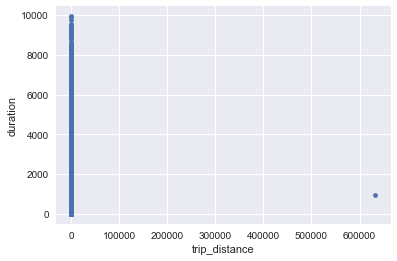

In [9]:
df.plot(x='trip_distance',y='duration',kind='scatter')

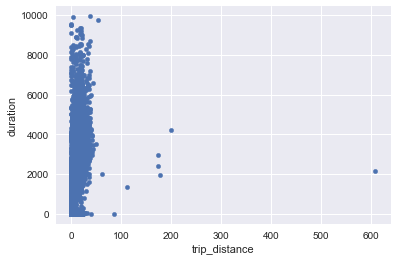

In [10]:
#Because there is an outlier that makes the graph not that readable, I'll delete that point to have a detailed look into the main part in the left.
df[df['trip_distance']<600000].plot(x='trip_distance',y='duration',kind='scatter')

<h2>Create a column "day_of_week" that puts in an integer for the weekday</h2>
<li>Monday = 1, Sunday = 7

In [11]:
df['day_of_week'] = df['tpep_pickup_datetime'].apply(lambda x: x.isoweekday())

<h2>Create time of day buckets using the hour part of tpep_pickup_datetime</h2>

In [12]:
df['pickup_hour'] = df['tpep_pickup_datetime'].apply(lambda x: x.hour)

<h2>Plot a bar graph that groups the data by day of week and then by time of day</h2>

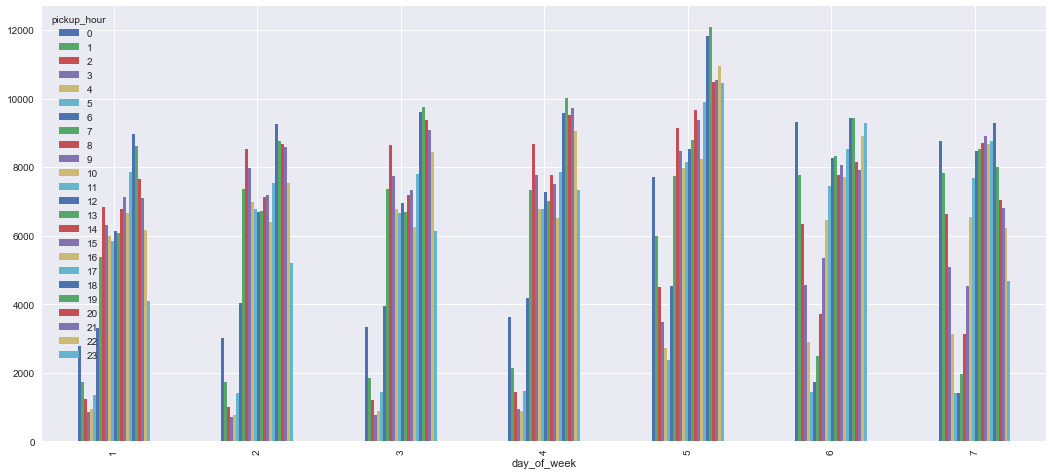

In [13]:
df.groupby(['day_of_week','pickup_hour']).size().unstack().plot(kind='bar',figsize=(18,8))

<h2>Create zones and GeoJsonObject</h2>

In [14]:
def createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596):
    zone_table = list()
    lat_section= (northlimit-southlimit)/zone_factor
    lon_section= (eastlimit-westlimit)/zone_factor
    for i in range(zone_factor):
        for j in range(zone_factor):
            zone_name=f'{i}_{j}'
            point1=[lon_section*j+westlimit,lat_section*i+southlimit]
            point2=[lon_section*(j+1)+westlimit,lat_section*i+southlimit]
            point3=[lon_section*(j+1)+westlimit,lat_section*(i+1)+southlimit]
            point4=[lon_section*j+westlimit,lat_section*(i+1)+southlimit]
            zone_table.append(tuple([zone_name,[point1,point2,point3,point4,point1]]))
    return zone_table

In [15]:
def createGeoJsonObject(zone_table):
    zone_data_dict = dict()
    zone_data_dict['type'] = 'FeatureCollection'
    zone_data_dict_features = list()
    zone_data_dict['features'] = zone_data_dict_features
    for item in zone_table:
        dic_inner={}
        dic_outer={}
        dic_inner['coordinates']=[item[1]]
        dic_inner['type']='Polygon'
        dic_outer['geometry']=dic_inner
        dic_outer['properties']={'zone_id':item[0]}
        dic_outer['type']='Feature'
        zone_data_dict_features.append(dic_outer) 
    return zone_data_dict

<h3>Create the zone table for zone_factor = 20</h3>

In [16]:
zone_factor=20
zone_table = createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596)
zone_table

[('0_0',
  [[-74.2635, 40.4856],
   [-74.237955, 40.4856],
   [-74.237955, 40.509299999999996],
   [-74.2635, 40.509299999999996],
   [-74.2635, 40.4856]]),
 ('0_1',
  [[-74.237955, 40.4856],
   [-74.21240999999999, 40.4856],
   [-74.21240999999999, 40.509299999999996],
   [-74.237955, 40.509299999999996],
   [-74.237955, 40.4856]]),
 ('0_2',
  [[-74.21240999999999, 40.4856],
   [-74.186865, 40.4856],
   [-74.186865, 40.509299999999996],
   [-74.21240999999999, 40.509299999999996],
   [-74.21240999999999, 40.4856]]),
 ('0_3',
  [[-74.186865, 40.4856],
   [-74.16131999999999, 40.4856],
   [-74.16131999999999, 40.509299999999996],
   [-74.186865, 40.509299999999996],
   [-74.186865, 40.4856]]),
 ('0_4',
  [[-74.16131999999999, 40.4856],
   [-74.135775, 40.4856],
   [-74.135775, 40.509299999999996],
   [-74.16131999999999, 40.509299999999996],
   [-74.16131999999999, 40.4856]]),
 ('0_5',
  [[-74.135775, 40.4856],
   [-74.11023, 40.4856],
   [-74.11023, 40.509299999999996],
   [-74.135775,

<h2>get_zone function that returns a zone number given a latitude and a longitude</h2>

In [17]:
def get_zone(lat,lon,zone_table):
    zone=''
    for item in zone_table:
        lon_=sorted(item[1],key=lambda x:x[0])
        lat_=sorted(item[1],key=lambda x:x[1])
        if (lon<lon_[-1][0] and lon>lon_[0][0]) and (lat<lat_[-1][1] and lat>lat_[0][1]):
            zone+=item[0]
        else:
            continue
    return zone
get_zone(40.65,-74.19,zone_table)

'6_2'

<h2>Create  pickup_zone and dropoff_zone columns for the dataframe</h2>

In [19]:
df['pickup_zone'] = df.apply(lambda x:get_zone(x['pickup_latitude'],x['pickup_longitude'],zone_table),axis=1)

In [20]:
df['dropoff_zone'] = df.apply(lambda x:get_zone(x['dropoff_latitude'],x['dropoff_longitude'],zone_table),axis=1)

In [21]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,day_of_week,pickup_hour,pickup_zone,dropoff_zone
0,1,2016-01-25 10:44:43,2016-01-25 10:55:40,1,1.00,-73.980652,40.765316,1,N,-73.989792,...,0.5,1.85,0.00,0.3,11.15,657.0,1,10,11_11,11_10
1,1,2016-01-13 10:19:36,2016-01-13 10:25:41,1,0.80,-73.948990,40.777428,1,N,-73.959045,...,0.5,1.36,0.00,0.3,8.16,365.0,3,10,12_12,12_11
2,2,2016-01-12 00:42:42,2016-01-12 00:51:04,1,2.17,-74.008377,40.735664,1,N,-74.013580,...,0.5,2.00,0.00,0.3,12.30,502.0,2,0,10_9,9_9
3,1,2016-01-10 16:21:17,2016-01-10 16:24:31,1,0.70,-73.961266,40.772495,1,N,-73.955887,...,0.5,1.30,0.00,0.3,6.60,194.0,7,16,12_11,12_12
4,2,2016-01-05 11:29:53,2016-01-05 11:52:24,5,0.78,-73.976532,40.764683,1,N,-73.966904,...,0.5,0.00,0.00,0.3,14.30,1351.0,2,11,11_11,11_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090681,2,2016-01-21 07:58:34,2016-01-21 08:10:57,1,1.98,-74.009941,40.720230,1,N,-73.990326,...,0.5,2.16,0.00,0.3,12.96,743.0,4,7,9_9,10_10
1090682,1,2016-01-07 01:15:38,2016-01-07 01:19:36,2,1.10,-73.971550,40.782257,1,N,-73.961464,...,0.5,0.00,0.00,0.3,6.80,238.0,4,1,12_11,13_11
1090683,1,2016-01-09 10:42:32,2016-01-09 10:50:34,2,1.30,-74.000137,40.733067,1,N,-73.999969,...,0.5,1.65,0.00,0.3,9.95,482.0,6,10,10_10,9_10
1090684,1,2016-01-10 15:34:00,2016-01-10 15:56:06,1,8.80,-73.874496,40.774082,1,N,-73.970444,...,0.5,6.75,5.54,0.3,40.59,1326.0,7,15,12_15,13_11


<h2>Calculate:</h2>
<li>Percentage of the total rides where the pickup zone is the same as the dropoff zone
<li>Zone with the highest pickups
<li>Zone with the highest dropoffs

In [22]:
import numpy as np
df['P_D']=np.where(df['pickup_zone']==df['dropoff_zone'],1,0)
df.groupby('P_D').size()
total_ride=df.groupby('P_D').size().loc[0]+df.groupby('P_D').size().loc[1]
ride=df.groupby('P_D').size().loc[1]
pct=ride/total_ride*100
pct
'Percentage of the total rides where the pickup zone is the same as the dropoff zone is %f%%' % pct

'Percentage of the total rides where the pickup zone is the same as the dropoff zone is 23.668056%'

In [23]:
for index,value in enumerate(df.groupby('pickup_zone').size()):
    if value==df.groupby('pickup_zone').size().max():
        zone_pickup=df.groupby('pickup_zone').size().index[index]
    else:
        continue
zone_pickup

'11_11'

In [24]:
for index,value in enumerate(df.groupby('dropoff_zone').size()):
    if value==df.groupby('dropoff_zone').size().max():
        zone_dropoff=df.groupby('dropoff_zone').size().index[index]
    else:
        continue
zone_dropoff

'11_11'

<h2>Groupby analysis</h2>
<li>Group data by the hour of the day and by the pickup zone
<li>Draw a figure of 24 plots that show the top 5 pickup zones at each hour


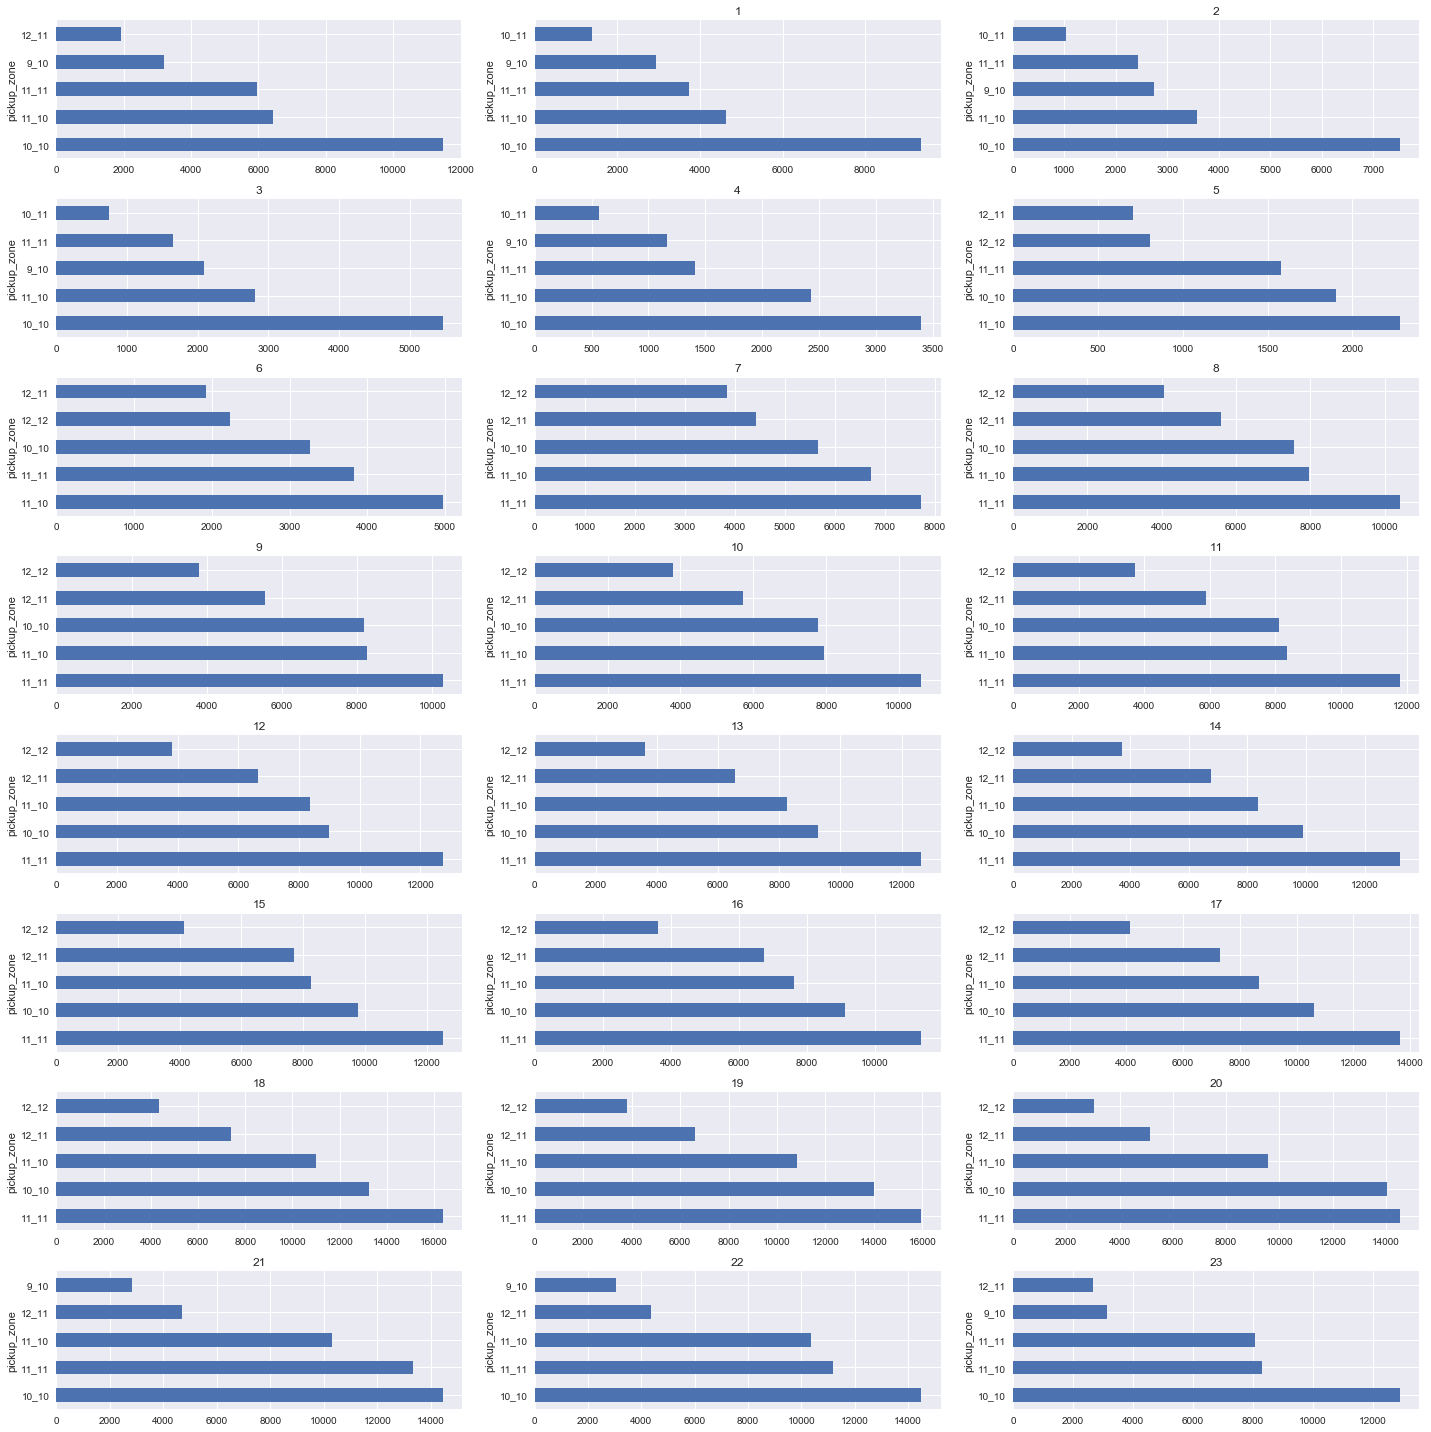

In [25]:
df_hz=df.groupby(['pickup_hour','pickup_zone']).size().unstack()
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('seaborn')
fig,axes=plt.subplots(8,3,figsize=(20,20))
for index in df_hz.index:
    ax=axes[int(index/3),index%3]
    df_hz.loc[index].sort_values(ascending=False)[:5].plot(ax=ax,kind='barh',title=index)
plt.tight_layout()

<h2>Groupby analysis 2</h2>
<li>Group data by the weekday and the pickup zone
<li>Draw a figure of 7 plots that show the top 5 pickup zones on each day

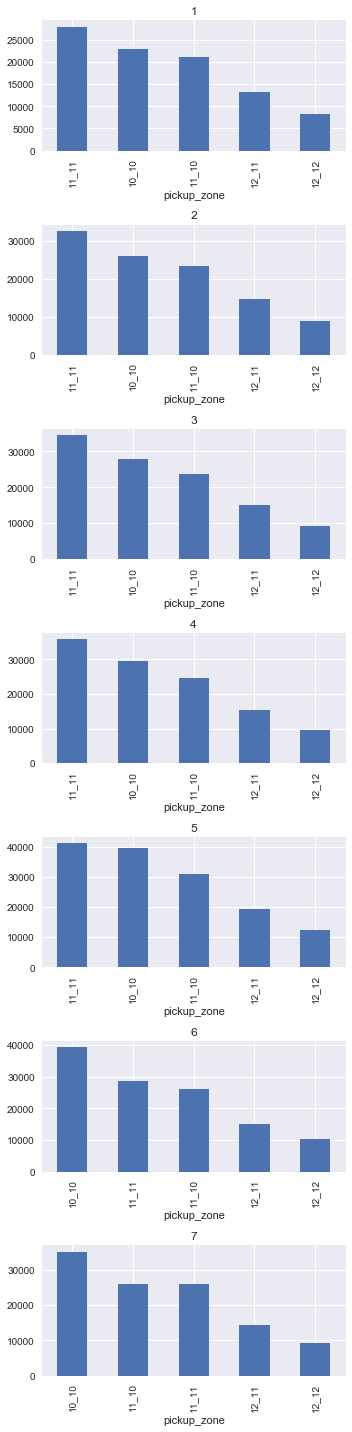

In [26]:
df_ap=df.groupby(['day_of_week','pickup_zone']).size().unstack()
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('seaborn')
fig,axes=plt.subplots(7,1,figsize=(5,20))
for index in df_ap.index:
    ax=axes[index-1]
    df_ap.loc[index].sort_values(ascending=False)[:5].plot(ax=ax,kind='bar',title=index)
plt.tight_layout()

<h1>Most frequent morning pickups</h1>
<li>Identify the most frequent pickup zone between 8 am and 9 am on a weekday



In [27]:
df_max=df[(df['pickup_hour']==8) & (df['day_of_week']<6)].groupby(['day_of_week','pickup_zone']).size().unstack()
for index in df_max.index:
    zone_name_=df_max.loc[index].sort_values(ascending=False).index[0]
    print (f'The most frequent pickup zone between 8 am and 9 am on weekday{index} is {zone_name_}.')

The most frequent pickup zone between 8 am and 9 am on weekday1 is 11_11.
The most frequent pickup zone between 8 am and 9 am on weekday2 is 11_11.
The most frequent pickup zone between 8 am and 9 am on weekday3 is 11_11.
The most frequent pickup zone between 8 am and 9 am on weekday4 is 11_11.
The most frequent pickup zone between 8 am and 9 am on weekday5 is 11_11.


<h2>Mapping</h2>

In [28]:
df_size=pd.DataFrame(df.groupby('pickup_zone').size())
df_size.reset_index(inplace=True)
#df_size.rename(['0','size'])
df_size.rename(columns={0:'size'},inplace=True)
df_size

,pickup_zone,size
0,10_0,1
1,10_10,220459
2,10_11,42146
3,10_12,1387
4,10_13,1566
...,...,...
202,9_4,4
203,9_6,3
204,9_7,3
205,9_8,35


In [29]:
import folium
m=folium.Map(location=[40.4856,-74.2635],zoom_start=12)

In [30]:
import json
geo_=json.dumps(createGeoJsonObject(zone_table))

In [31]:
m.choropleth(geo_data=geo_,data=df_size,columns=['pickup_zone','size'],
             key_on='feature.properties.zone_id',fill_color='RdYlGn',
             fill_opacity=0.7, line_opacity=0.8,legend_name='Distribution of Pickup-zone')
m

C:\Users\April\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [32]:
df_review=df.groupby(['pickup_zone']).size()
df_review
zone_area=[f'{i}_{j}' for i in range(20) for j in range(20)]
for i in df_review.dropna().index:
    if i in zone_area:
        zone_area.remove(i)
for i in zone_area:
    for j in zone_table:
        if j[0]==i:
            zone_table.remove(j)

In [33]:
zone_table

[('1_4',
  [[-74.16131999999999, 40.509299999999996],
   [-74.135775, 40.509299999999996],
   [-74.135775, 40.533],
   [-74.16131999999999, 40.533],
   [-74.16131999999999, 40.509299999999996]]),
 ('2_9',
  [[-74.03359499999999, 40.533],
   [-74.00805, 40.533],
   [-74.00805, 40.5567],
   [-74.03359499999999, 40.5567],
   [-74.03359499999999, 40.533]]),
 ('3_5',
  [[-74.135775, 40.5567],
   [-74.11023, 40.5567],
   [-74.11023, 40.5804],
   [-74.135775, 40.5804],
   [-74.135775, 40.5567]]),
 ('3_6',
  [[-74.11023, 40.5567],
   [-74.084685, 40.5567],
   [-74.084685, 40.5804],
   [-74.11023, 40.5804],
   [-74.11023, 40.5567]]),
 ('3_10',
  [[-74.00805, 40.5567],
   [-73.982505, 40.5567],
   [-73.982505, 40.5804],
   [-74.00805, 40.5804],
   [-74.00805, 40.5567]]),
 ('3_11',
  [[-73.982505, 40.5567],
   [-73.95696, 40.5567],
   [-73.95696, 40.5804],
   [-73.982505, 40.5804],
   [-73.982505, 40.5567]]),
 ('3_12',
  [[-73.95696, 40.5567],
   [-73.931415, 40.5567],
   [-73.931415, 40.5804],
 

In [34]:
m_1=folium.Map(location=[40.4856,-74.2635],zoom_start=12)
geo_1=json.dumps(createGeoJsonObject(zone_table))
m_1.choropleth(geo_data=geo_1,data=df_size,columns=['pickup_zone','size'],
             key_on='feature.properties.zone_id',fill_color='RdYlGn',
             fill_opacity=0.7, line_opacity=0.8,legend_name='Distribution of Pickup-zone')
m_1